In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

### Data preparation

In [2]:
df = pd.read_csv('data3.csv')
df.head()

,ID,Age18,Age19,Age20,Age21,Age22,Age23,Age24,Age25,Age26,Age27,Age28,Age29,Age30,Age31,Age32,Age33,Age34
0,MCKINNONLARRY34023,0,0,0,0,0,8,13,3,5,1,3,0,2,1,0,0,0
1,PIERREDENEL34702,0,0,0,2,1,0,5,5,3,5,12,1,0,0,0,0,0
2,FELTONQUANDRECHRISTOPHER35265,0,2,13,12,0,2,2,2,0,1,0,0,0,0,0,0,0
3,JEANEDWIN34368,0,0,0,1,4,5,6,4,3,3,4,3,0,0,0,0,0
4,GONZALEZLEANDROFELIX34204,0,0,0,0,1,0,0,0,5,8,9,6,0,0,0,0,0


In [3]:
# exclude id col and reshape data
data_for_hmm = df.iloc[:, 1:].values  
lengths = [len(row) for row in data_for_hmm]
data_for_hmm = np.concatenate(data_for_hmm).reshape(-1, 1)

### Running GBTM

In [4]:
# fit HMM and calculate BIC for a given number of components
def fit_hmm(n_components):
    model = hmm.PoissonHMM(n_components=n_components, n_iter=100, random_state=42)
    model.fit(data_for_hmm, lengths=lengths)
    return model, model.bic(data_for_hmm)

In [5]:
# determine best n components based on BIC
best_model, best_bic, best_n_components = None, float('inf'), 0
for n_components in range(4,8): 
    model, bic = fit_hmm(n_components)
    if bic < best_bic:
        best_bic = bic
        best_model = model
        best_n_components = n_components

In [7]:
# assign each geographic place /or individual if using person data/ to a group
group_assignments = np.split(best_model.predict(data_for_hmm), np.cumsum(lengths)[:-1])

# extract probabilities for each place/individual for each group
group_probabilities = np.split(best_model.predict_proba(data_for_hmm), np.cumsum(lengths)[:-1])

### Collating results

In [8]:
# results with IDs for interpretable table view
results = pd.DataFrame({
    'ID': df['ID'],
    'Group': [assignment[0] for assignment in group_assignments],
    'Probabilities': [prob[0] for prob in group_probabilities]
})

In [9]:
# output results
best_n_components, results.head()

(4,
                               ID  Group  \
 0             MCKINNONLARRY34023      2   
 1               PIERREDENEL34702      2   
 2  FELTONQUANDRECHRISTOPHER35265      2   
 3                 JEANEDWIN34368      2   
 4      GONZALEZLEANDROFELIX34204      2   
 
                                        Probabilities  
 0  [0.4466310631544113, 0.00013907182136774937, 0...  
 1  [0.32416935747206516, 0.0013745874272028675, 0...  
 2  [0.00037383865040356454, 0.08419286250056489, ...  
 3  [0.28917762311930845, 0.0015469059499775687, 0...  
 4  [0.308935945069664, 0.004801728434550145, 0.68...  )

In [10]:
ids = df['ID'].values 
group_assignments_flat = [assignment[0] for assignment in group_assignments]
max_probs = [np.max(prob[0]) for prob in group_probabilities]

# results as df
results_df = pd.DataFrame({
    'ID': ids,
    'Group': group_assignments_flat,
    'MaxPosteriorProbability': max_probs
})

# merge with original data
df_with_results = pd.merge(df, results_df, on='ID')
df_with_results

,ID,Age18,Age19,Age20,Age21,Age22,Age23,Age24,Age25,Age26,Age27,Age28,Age29,Age30,Age31,Age32,Age33,Age34,Group,MaxPosteriorProbability
0,MCKINNONLARRY34023,0,0,0,0,0,8,13,3,5,1,3,0,2,1,0,0,0,2,0.553230
1,PIERREDENEL34702,0,0,0,2,1,0,5,5,3,5,12,1,0,0,0,0,0,2,0.668905
2,FELTONQUANDRECHRISTOPHER35265,0,2,13,12,0,2,2,2,0,1,0,0,0,0,0,0,0,2,0.915429
3,JEANEDWIN34368,0,0,0,1,4,5,6,4,3,3,4,3,0,0,0,0,0,2,0.708059
4,GONZALEZLEANDROFELIX34204,0,0,0,0,1,0,0,0,5,8,9,6,0,0,0,0,0,2,0.681780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,THOMASJEAN35586,0,0,0,0,0,0,3,0,3,1,0,0,0,0,0,0,0,2,0.671101
996,YANESMAXLUIS34285,0,0,0,0,0,0,0,1,0,1,2,1,2,0,0,0,0,2,0.684055
997,THOMPSONROHANONEAL35584,0,0,1,2,4,0,0,0,0,0,0,0,0,0,0,0,0,2,0.752476
998,ZAPATAJONATHANANDRES35181,0,0,0,0,0,0,0,0,4,3,0,0,0,0,0,0,0,2,0.684307


### Plotting group mean trajectories

In [11]:
# select columns to include only the yearly crime count columns
crime_count_columns = df_with_results.columns[1:-2]  # exclude the first and the last 2 cols

# group by the 'Group' column and calculate the means
group_means = df_with_results.groupby('Group')[crime_count_columns].mean()

In [12]:
# extract avg 'MaxPosteriorProbability' column
average_max_posterior = results_df['MaxPosteriorProbability'].mean()
average_max_posterior

0.6891805442695372

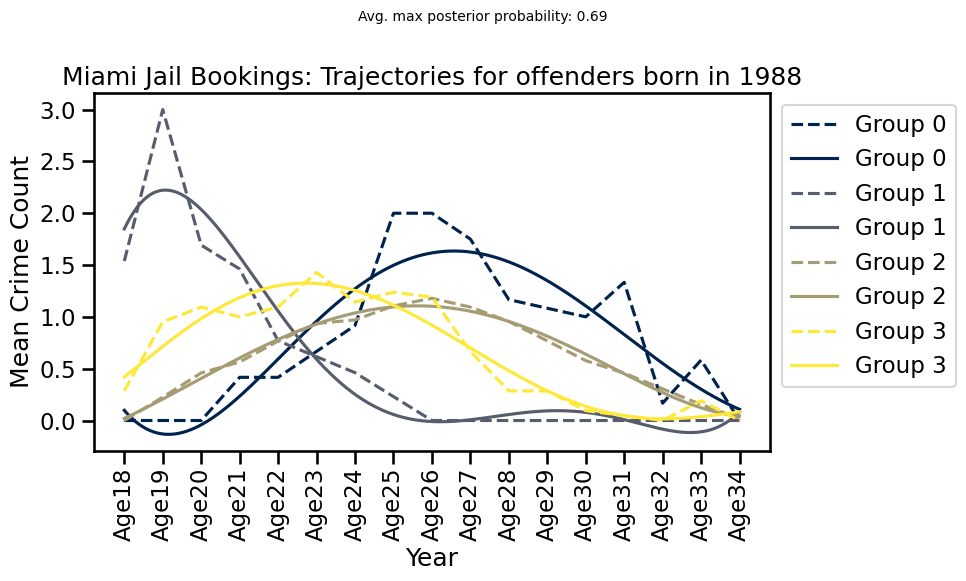

In [16]:
sns.set_context("talk")  

plt.figure(figsize=(10, 6))
plt.title('Miami Jail Bookings: Trajectories for offenders born in 1988')
plt.suptitle(f'Avg. max posterior probability: {average_max_posterior:.2f}', fontsize=10)

poly_degree = 5  
colors = plt.cm.cividis(np.linspace(0, 1, len(group_means.index))) 

for idx, group in enumerate(group_means.index):
    x = np.arange(len(crime_count_columns))
    y = group_means.loc[group, crime_count_columns]
    coeffs = np.polyfit(x, y, poly_degree)

    x_smooth = np.linspace(x.min(), x.max(), 500)
    y_smooth = np.polyval(coeffs, x_smooth)

    plt.plot(crime_count_columns, y, '--', color=colors[idx], label=f'Group {group}')
    plt.plot(x_smooth, y_smooth, color=colors[idx], label=f'Group {group}')

plt.xlabel('Year')
plt.ylabel('Mean Crime Count')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation='vertical')  
plt.tight_layout()  
plt.show()

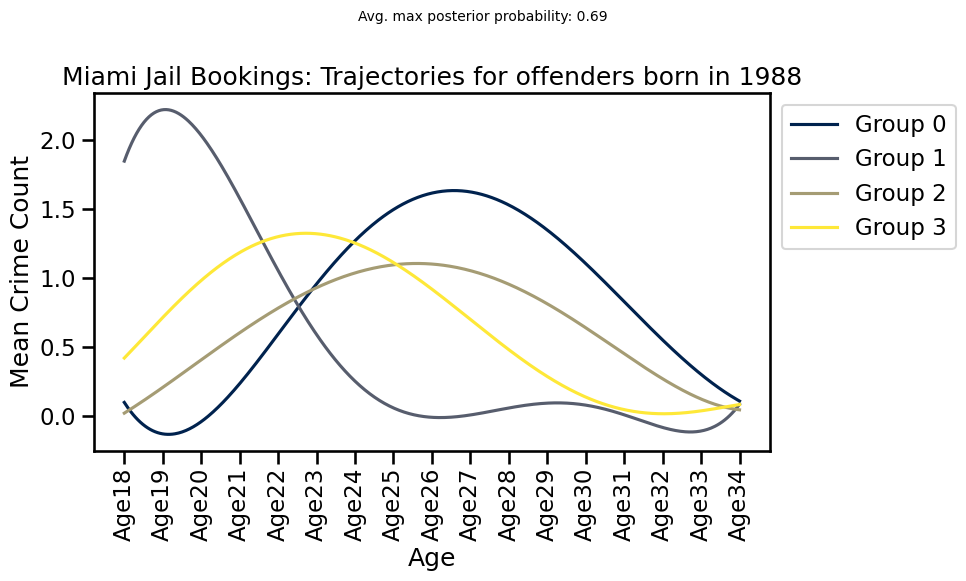

In [19]:
sns.set_context("talk")  # Set the context to "talk" for suitable presentation

plt.figure(figsize=(10, 6))
plt.title('Miami Jail Bookings: Trajectories for offenders born in 1988')
plt.suptitle(f'Avg. max posterior probability: {average_max_posterior:.2f}', fontsize=10)

poly_degree = 5  
colors = plt.cm.cividis(np.linspace(0, 1, len(group_means.index)))  # Use the 'cividis' colormap

for idx, group in enumerate(group_means.index):
    x = np.arange(len(crime_count_columns))
    y = group_means.loc[group, crime_count_columns]
    coeffs = np.polyfit(x, y, poly_degree)

    x_smooth = np.linspace(x.min(), x.max(), 500)
    y_smooth = np.polyval(coeffs, x_smooth)

    plt.plot(x_smooth, y_smooth, color=colors[idx], label=f'Group {group}')

# Set age labels for x-axis
age_labels = [f'Age{age}' for age in range(18, 18 + len(crime_count_columns))]  # Adjust range according to your data
plt.xticks(ticks=np.linspace(x.min(), x.max(), len(crime_count_columns)), labels=age_labels)  # Set custom x-axis labels

plt.xlabel('Age')
plt.ylabel('Mean Crime Count')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation='vertical') 
plt.tight_layout() 
plt.show()

### Export data

In [20]:
df_with_results.to_csv('miami_jb_gbta.csv')